In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.chdir('../..')

## 1. SST

In [3]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_SST_BERT.pickle', 'rb'))

In [4]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'contraction', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender'])

## Generate table heatmap
#### Note correction to k-intersection calculation

In [5]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue

    #     df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
    #     df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)

    #     df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1).mean(),
        'spearman_std': df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1).std()
    }

In [6]:
PERTURBATION_FULL_FORM_DICT = {
    'strip_punct': 'Strip end punctuation',
    'remove_commas': 'Remove commas',
    'remove_all_punct': 'Remove all punctuation',
    'change_last_name': 'Change last name',
    'add_typo': 'Add typo',
    'switch_gender': 'Switch gender'
}

In [7]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std
Strip end punctuation,0.810567,0.281089,0.828604,0.222771
Remove commas,0.562468,0.351917,0.575851,0.344340
Remove all punctuation,0.671084,0.317699,0.613300,0.338623
Add typo,0.816000,0.299223,0.856433,0.179206
Switch gender,0.883146,0.240849,0.924135,0.139937


In [8]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [9]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,label_top_k,label_spearman
Strip end punctuation,0.810567,0.281089,0.828604,0.222771,0.81 (±0.28),0.83 (±0.22)
Remove commas,0.562468,0.351917,0.575851,0.344340,0.56 (±0.35),0.58 (±0.34)
Remove all punctuation,0.671084,0.317699,0.613300,0.338623,0.67 (±0.32),0.61 (±0.34)
Add typo,0.816000,0.299223,0.856433,0.179206,0.82 (±0.3),0.86 (±0.18)
Switch gender,0.883146,0.240849,0.924135,0.139937,0.88 (±0.24),0.92 (±0.14)


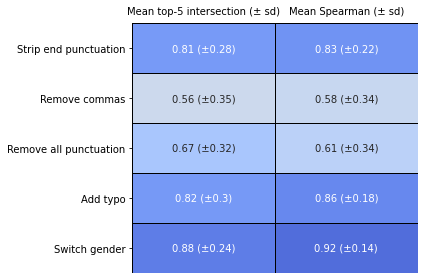

In [10]:
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman'], axis=1), 
    cbar=False, 
    vmin=0,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.show()

### Explore individual cases

In [104]:
def plot_examples(perturbation, num_examples, return_df=False):
    
    perturbation_df = perturbation_df_dict[perturbation].copy()
    
    for _ in range(num_examples):
        idx = np.random.choice(len(perturbation_df))
        example = perturbation_df.iloc[idx]
        
        example_df = pd.DataFrame({
            'shap_orig_tokens': example['shap_orig_tokens'],
            'shap_orig_values': example['shap_orig_values'],
            f'shap_{perturbation}_tokens': example[f'shap_{perturbation}_tokens'],
            f'shap_{perturbation}_values': example[f'shap_{perturbation}_values']
        })
        
        # MinMax scale to get scores within 0,1
        example_df['shap_orig_values'] = MinMaxScaler().fit_transform(example_df['shap_orig_values'].values.reshape(-1, 1)).flatten()
        example_df[f'shap_{perturbation}_values'] = MinMaxScaler().fit_transform(example_df[f'shap_{perturbation}_values'].values.reshape(-1, 1)).flatten()
        
        # Sort by SHAP scores before perturbation
        example_df.sort_values('shap_orig_values', ascending=False, inplace=True)
        example_df.reset_index(drop=True, inplace=True)
        
        print(f"Original sentence: {example['sentence']}")
        print(f"Model prediction: {example['orig_prediction']}")
        print(f"Top-5 intersection: {example['k_intersection']}")
        print(f"Spearman: {np.round(example['spearman'], 2)}")
        
        plt.figure(figsize=(10, 4))
        ax = sns.barplot(x=example_df.index, y='shap_orig_values', data=example_df, ci=None, color='blue', alpha=0.3, label='Original')
        ax = sns.barplot(x=example_df.index, y=f'shap_{perturbation}_values', data=example_df, ci=None, color='red', alpha=0.3, label=PERTURBATION_FULL_FORM_DICT[perturbation])
        ax.set_xticklabels(example_df['shap_orig_tokens'])
        ax.set_xlabel('Token')
        ax.set_ylabel('Normalised SHAP score')
        plt.xticks(rotation=90)
        plt.legend()
        plt.show()
        
        if return_df:
            return example_df


strip_punct

Original sentence: Portentous and pretentious , The Weight of Water is appropriately titled , given the heavy-handedness of it drama .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.95


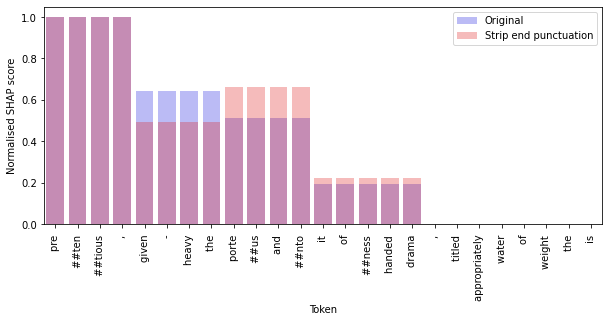

Original sentence: It 's basically an overlong episode of Tales from the Crypt .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


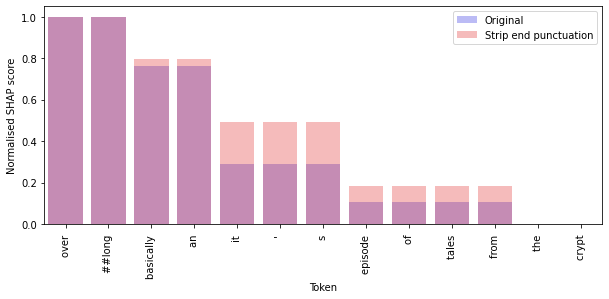

Original sentence: Has a lot of the virtues of Eastwood at his best .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.98


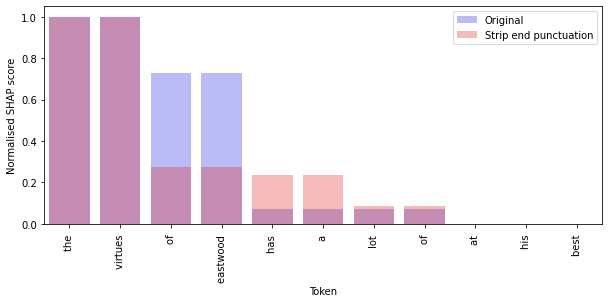

Original sentence: The longer the movie goes , the worse it gets , but it 's actually pretty good in the first few minutes .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.88


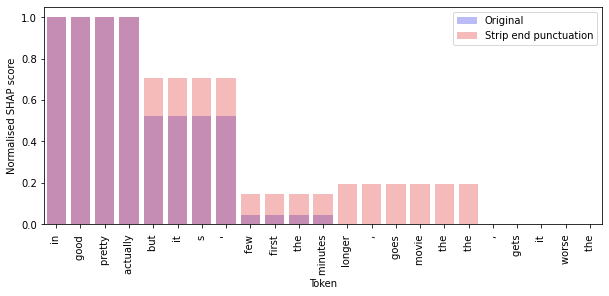

Original sentence: Without ever becoming didactic , director Carlos Carrera expertly weaves this novelistic story of entangled interrelationships and complex morality .
Model prediction: 3
Top-5 intersection: 0.6
Spearman: 0.65


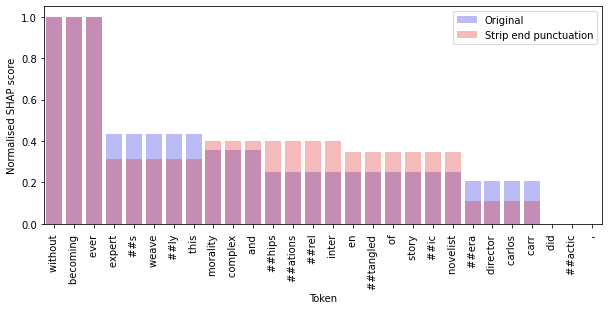




remove_commas

Original sentence: Slapstick buffoonery can tickle many a preschooler 's fancy , but when it costs a family of four about $ 40 to see a film in theaters , why spend money on a dog like this when you can rent a pedigree instead ?
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.79


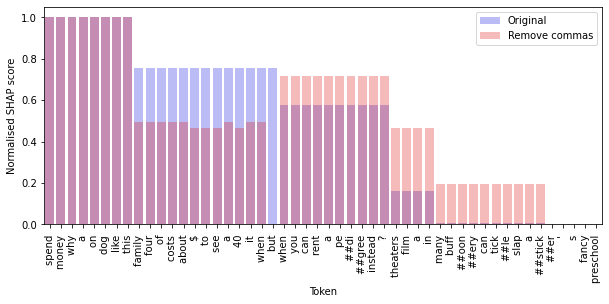

Original sentence: The tale of Tok ( Andy Lau ) , a sleek sociopath on the trail of O ( Takashi Sorimachi ) , the most legendary of Asian hitmen , is too scattershot to take hold .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.65


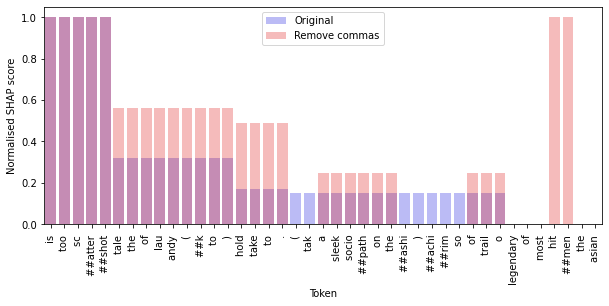

Original sentence: Excessive , profane , packed with cartoonish violence and comic-strip characters .
Model prediction: 1
Top-5 intersection: 0.4
Spearman: 0.62


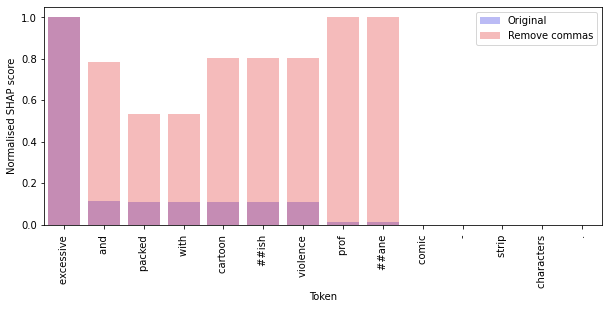

Original sentence: Even on those rare occasions when the narrator stops yammering , Miller 's hand often feels unsure .
Model prediction: 2
Top-5 intersection: 0.8
Spearman: 0.64


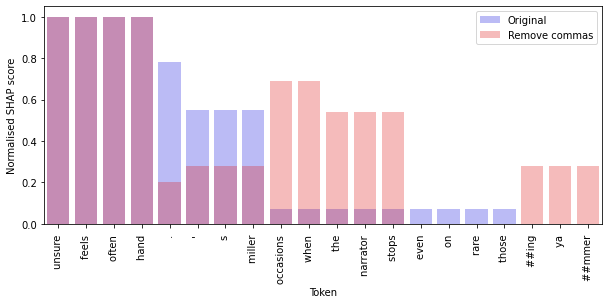

Original sentence: If you believe any of this , I can make you a real deal on leftover Enron stock that will double in value a week from Friday .
Model prediction: 2
Top-5 intersection: 0.8
Spearman: 0.45


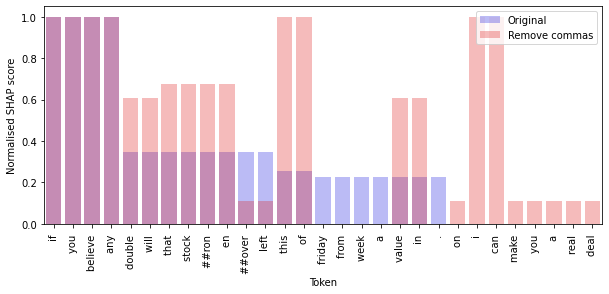




remove_all_punct

Original sentence: The movie is beautiful to behold and engages one in a sense of epic struggle -- inner and outer -- that 's all too rare in Hollywood 's hastier productions .
Model prediction: 3
Top-5 intersection: 0.0
Spearman: 0.57


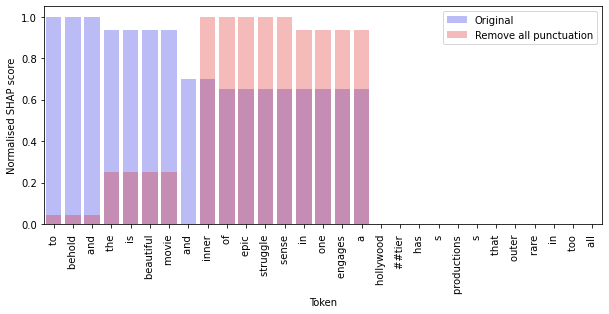

Original sentence: Light years / several warp speeds / levels and levels of dilithium crystals better than the pitiful Insurrection .
Model prediction: 3
Top-5 intersection: 0.2
Spearman: -0.64


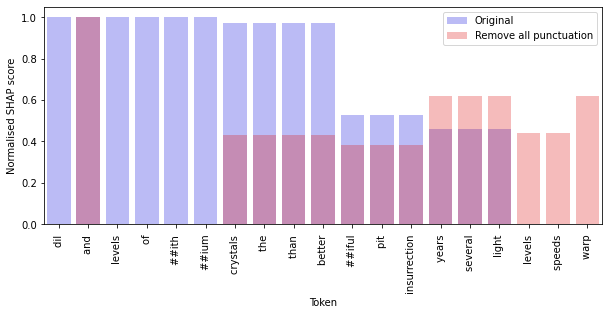

Original sentence: A perplexing example of promise unfulfilled , despite many charming moments .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.91


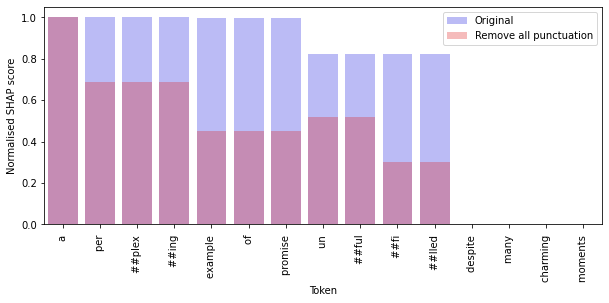

Original sentence: Stealing Harvard aspires to comedic grand larceny but stands convicted of nothing more than petty theft of your time .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.29


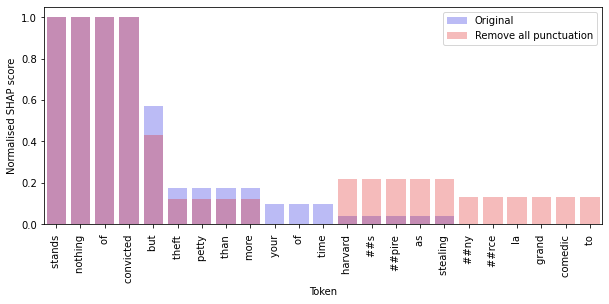

Original sentence: Intriguing documentary which is emotionally diluted by focusing on the story 's least interesting subject .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.9


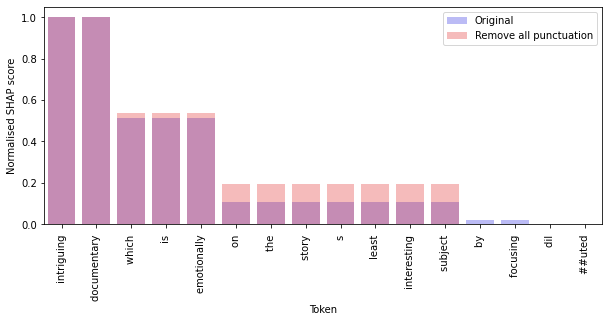




switch_gender

Original sentence: Not since Tom Cruise in Risky Business has an actor made such a strong impression in his underwear .
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.95


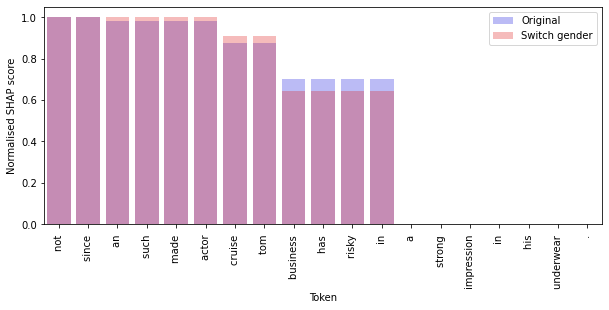

Original sentence: The entire movie is about a boring , sad man being boring and sad .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


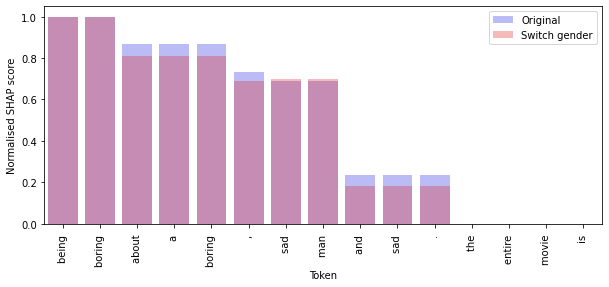

Original sentence: Prancing his way through the tailor-made part of a male hooker approaching the end of his vitality , Jagger obviously relishes every self-mocking moment .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.96


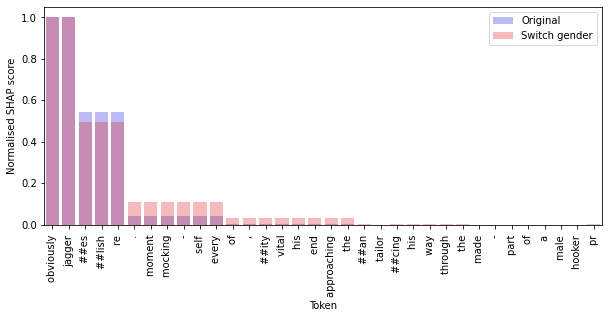

Original sentence: Broomfield turns his distinctive ` blundering ' style into something that could really help clear up the case .
Model prediction: 3
Top-5 intersection: 0.2
Spearman: 0.85


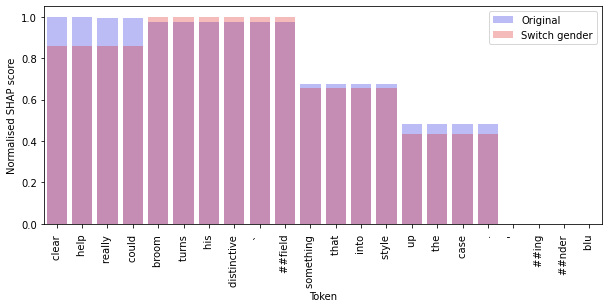

Original sentence: The character of ZigZag is not sufficiently developed to support a film constructed around him .
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


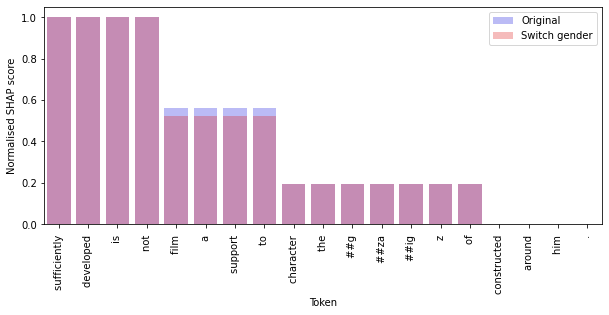




add_typo

Original sentence: A romantic comedy enriched by a sharp eye for manners and mores .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.81


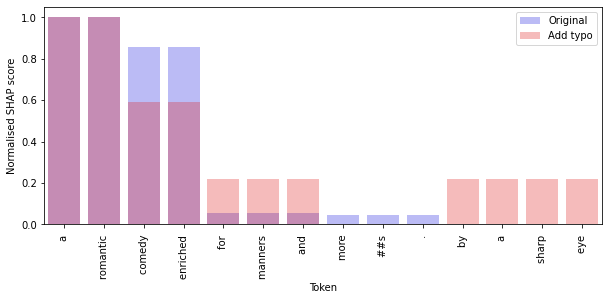

Original sentence: It 's not without its pleasures , but I 'll stick with The Tune .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.99


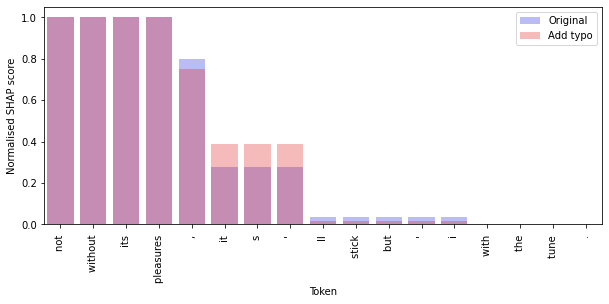

Original sentence: For anyone unfamiliar with pentacostal practices in general and theatrical phenomenon of Hell Houses in particular , it 's an eye-opener .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.84


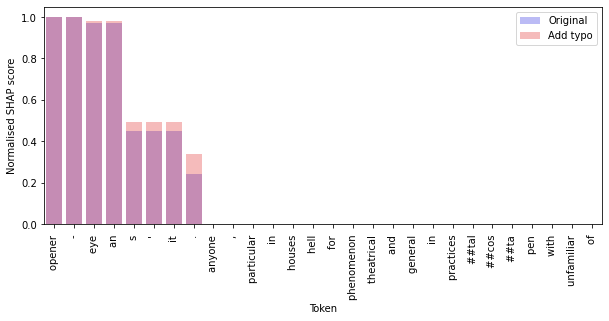

Original sentence: At times , the suspense is palpable , but by the end there 's a sense that the crux of the mystery hinges on a technicality that strains credulity and leaves the viewer haunted by the waste of potential .
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.99


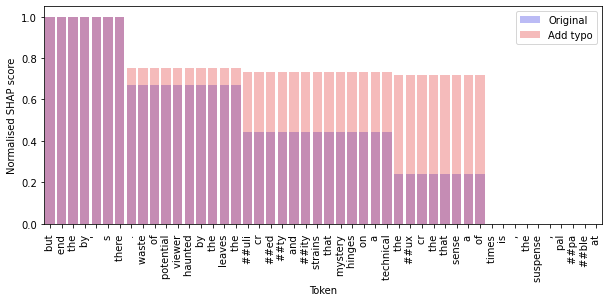

Original sentence: It 's not without its pleasures , but I 'll stick with The Tune .
Model prediction: 3
Top-5 intersection: 1.0
Spearman: 0.99


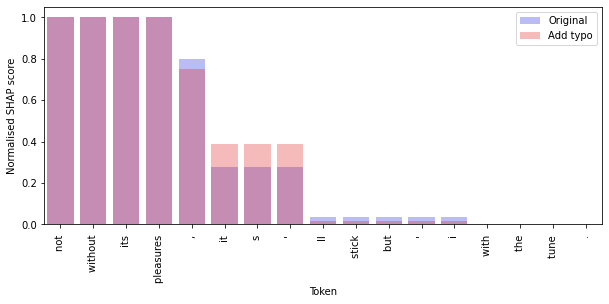

In [105]:
for pert in ['strip_punct', 'remove_commas', 'remove_all_punct', 'switch_gender', 'add_typo']:  # 'change_last_name',
    print(
f"""
================================================
{pert}
================================================
"""
)
    plot_examples(perturbation=pert, num_examples=5)
    print('\n')

## Check examples

In [136]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [137]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,of,1.0,of,0.544082
1,the,1.0,the,0.544082
2,film,1.0,film,0.362133
3,the,1.0,the,0.544082
4,majority,1.0,majority,0.544082


In [138]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [150]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [151]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
5,his,0.789417,her,1.000000
8,he,0.612589,she,0.654182
14,he,0.181150,she,0.767357


In [158]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [159]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
19,a,0.0,sa,0.009557
24,enjoys,0.0,enjoy,0.009557


## 2. AG News

In [160]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_AGNews_BERT.pickle', 'rb'))

In [161]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'contraction', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender'])

## Generate table heatmap
#### Note correction to k-intersection calculation

In [162]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    if perturbation == 'swap_adj':
        continue

    #     df['top_k_idx_orig'] = df.apply(lambda x: np.argsort(-np.array(x[f'shap_orig_values']))[:k], axis=1)
    #     df['top_k_idx_perturb'] = df.apply(lambda x: np.argsort(-x[f'shap_{perturbation}_values'])[:k], axis=1)

    #     df['k_intersection'] = df.apply(lambda x: (x['top_k_idx_orig'] == x['top_k_idx_perturb']).mean(), axis=1)

    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1).mean(),
        'spearman_std': df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1).std()
    }

In [163]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std
Strip end punctuation,0.763942,0.304738,0.871257,0.196845
Remove commas,0.498462,0.382318,0.582168,0.332249
Remove all punctuation,0.413825,0.357451,0.477600,0.363618
Change last name,0.900000,0.200000,0.965109,0.059713
Add typo,0.876923,0.240512,0.950742,0.090019
Switch gender,0.857403,0.261683,0.940897,0.110239


In [164]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [165]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,label_top_k,label_spearman
Strip end punctuation,0.763942,0.304738,0.871257,0.196845,0.76 (±0.3),0.87 (±0.2)
Remove commas,0.498462,0.382318,0.582168,0.332249,0.5 (±0.38),0.58 (±0.33)
Remove all punctuation,0.413825,0.357451,0.477600,0.363618,0.41 (±0.36),0.48 (±0.36)
Change last name,0.900000,0.200000,0.965109,0.059713,0.9 (±0.2),0.97 (±0.06)
Add typo,0.876923,0.240512,0.950742,0.090019,0.88 (±0.24),0.95 (±0.09)
Switch gender,0.857403,0.261683,0.940897,0.110239,0.86 (±0.26),0.94 (±0.11)


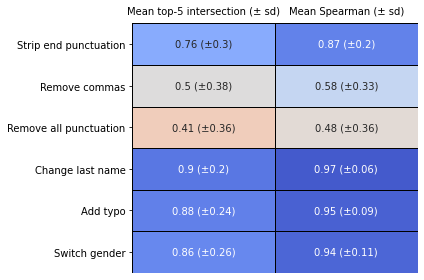

In [166]:
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman'], axis=1), 
    cbar=False, 
    vmin=0,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.show()

### Explore individual cases


strip_punct

Original sentence: He has won 20. He has saved 50. And now that he';s back in the Braves'; starting rotation, he';ll probably win 20 again. John Smoltz last started a game back in the 2001 season.
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.94


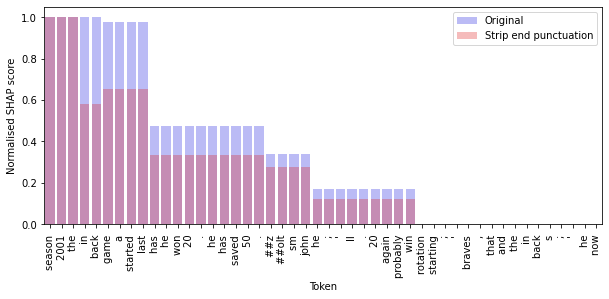

Original sentence: McDonald';s Corp. said Thursday that global comparable-restaurant sales, or sales at restaurants open at least 13 months, rose 4.2 percent in November.
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 0.99


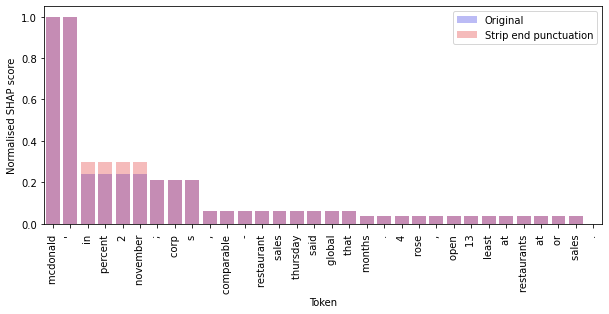

Original sentence: CBC SPORTS ONLINE - The Houston Rockets activated point guard Tyronn Lue off the injured list Wednesday. Lue, who missed five games with a sore right knee, had four points, an assist and a steal in Houston';s 92-69 victory over the Atlanta Hawks.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


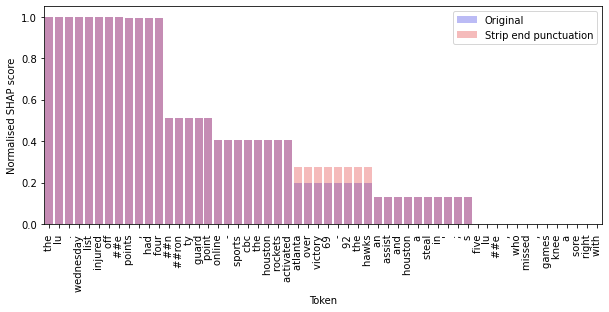

Original sentence: AC MILAN striker Andriy Shevchenko gave his strife-torn country Ukraine some reason for celebration when he was named European footballer of the year for 2004 yesterday.
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.5


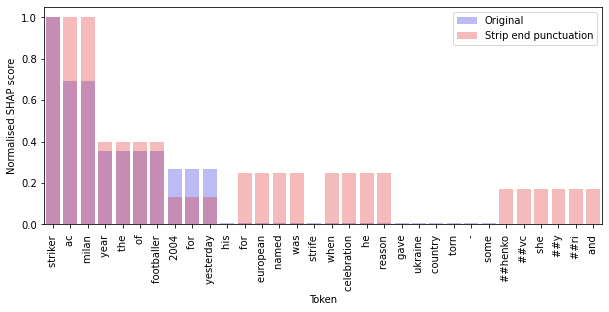

Original sentence: DUBAI (AFP) - Dubai Ports International (DPI), a leading world port operator, announced it had acquired the international terminal business conducted by CSX World Terminals (CSXWT) for 1.15 billion dollars.
Model prediction: 2
Top-5 intersection: 0.4
Spearman: 0.98


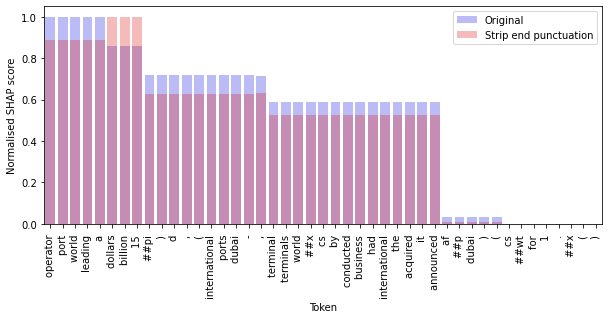




remove_commas

Original sentence: Mumbai, Dec. 11: Singapore Technologies Telemedia (ST Telemedia) and TM International have together acquired a 47.7 per cent stake in Idea Cellular for approximately $390 million.
Model prediction: 2
Top-5 intersection: 1.0
Spearman: 0.89


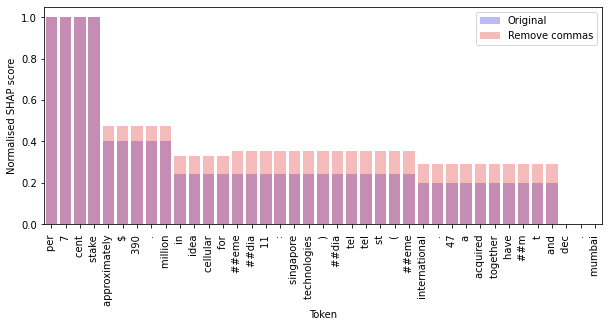

Original sentence: NASA should be able to meet all the requirements for resuming space shuttle flights next spring, an oversight panel said.
Model prediction: 3
Top-5 intersection: 0.6
Spearman: 0.64


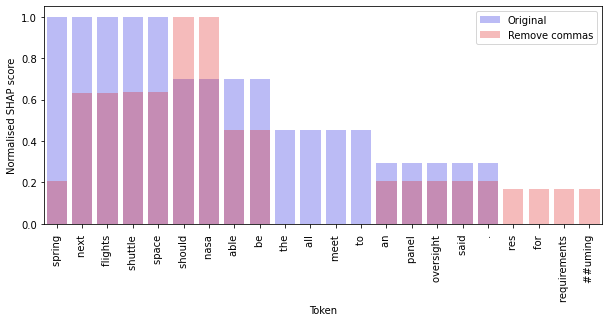

Original sentence: Andy Roddick has sacked Brad Gilbert, the coach who guided him to world number one and the US Open crown in 2003. No reason has been given for the split.
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.59


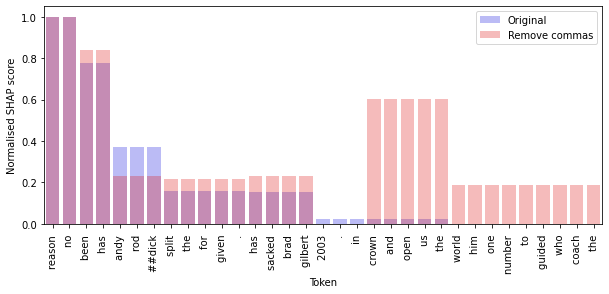

Original sentence: MOSCOW - Russia is vowing to proceed with an auction of oil giant Yukos'; key production subsidiary, saying a US court ban is irrelevant.
Model prediction: 2
Top-5 intersection: 0.2
Spearman: 0.79


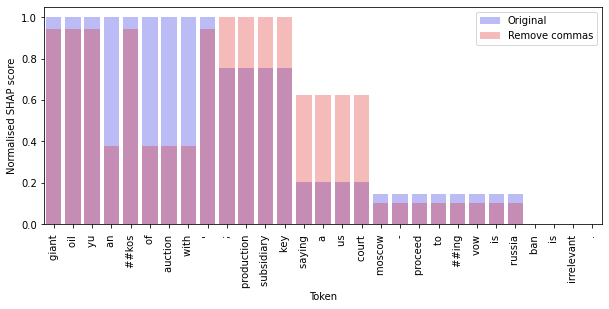

Original sentence: Actor Sidney Poitier, a former Walt Disney Co. director, said he supported firing ex-company president Michael Ovitz because he was mismatched with other executives.
Model prediction: 2
Top-5 intersection: 0.2
Spearman: 0.77


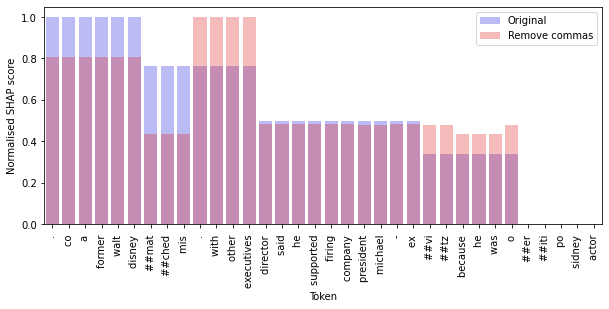




remove_all_punct

Original sentence: Shocked by a mediocre post-Thanksgiving weekend, merchants are rushing to mark down their merchandise - before the majority of holiday shoppers have even seen it.
Model prediction: 2
Top-5 intersection: 0.2
Spearman: 0.12


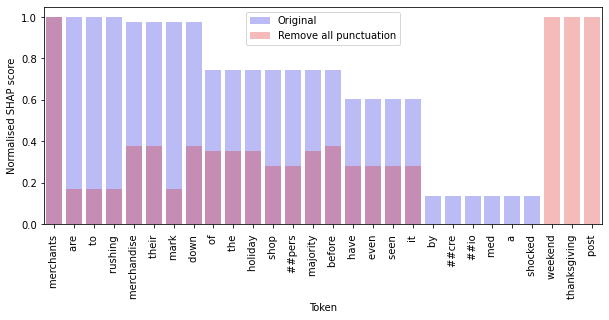

Original sentence: There was a time when knocking out Mike Tyson was boxing';s equivalent to beating Ken Jennings at Final Jeopardy. It was the most Heruculean of labors and when it finally happened, it was an international event 
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.71


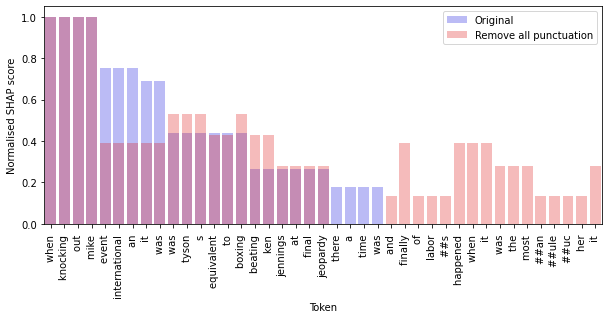

Original sentence:  quot;Now Conte has broken his silence, they will be seeking him for further information. The IAAF will follow the situation, quot; he said.
Model prediction: 1
Top-5 intersection: 0.6
Spearman: 0.67


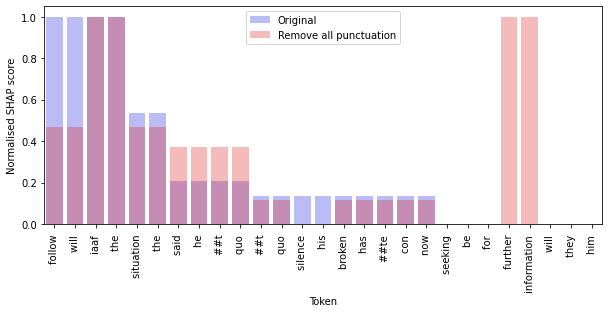

Original sentence: Fannie Mae yesterday agreed to pay the government $7.5 million to settle a case in which the Justice Department alleged that the giant housing-finance company knowingly accepted proceeds of a mortgage scam.
Model prediction: 2
Top-5 intersection: 0.0
Spearman: 0.5


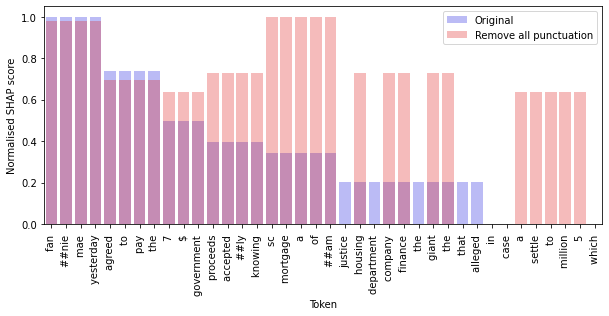

Original sentence:  BEIJING (Reuters) - China and Russia will hold their first  joint military exercises on Chinese territory next year, the  Interfax news agency quoted Russian Defense Minister Sergei  Ivanov as saying in Beijing on Monday.
Model prediction: 0
Top-5 intersection: 0.0
Spearman: 0.27


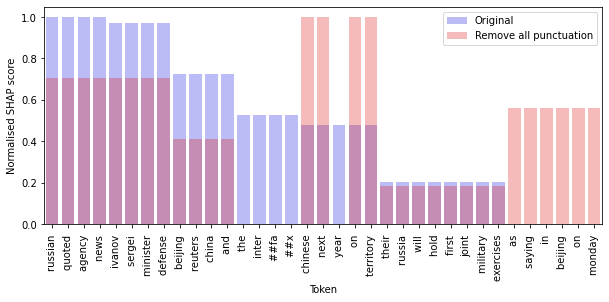




switch_gender

Original sentence: MOSUL: The bodies of six young men, all shot in the head as if executed, were discovered in the northern Iraqi city of Mosul on Tuesday, bringing the total of such corpses found to 14 in two days.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.99


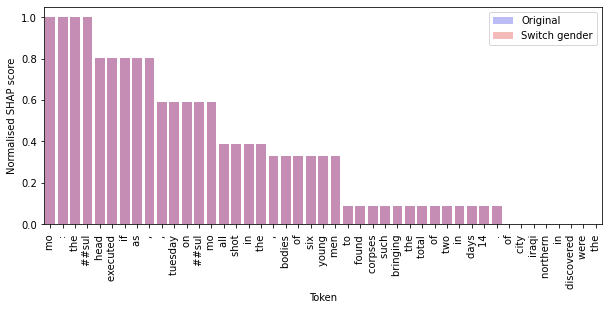

Original sentence: Newly signed New York Mets pitcher Pedro Martinez leveled criticism of former Boston Red Sox teammate Curt Schilling, telling the Boston Herald he';s much better and that Schilling was off-base when talking about Martinez';s workout regimen.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.98


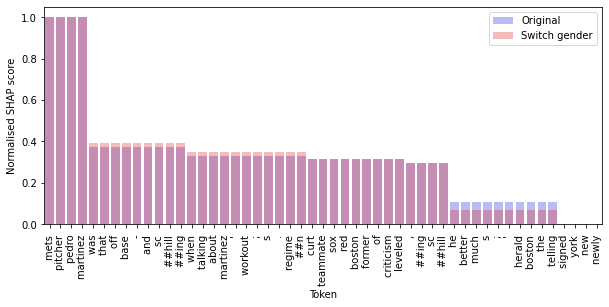

Original sentence: Isiah Thomas emerged from the Madison Square Garden shadows yesterday morning, gushed about his team';s break-even pace and swatted away the trade rumors that have chased the Knicks through the first quarter of the season.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 0.99


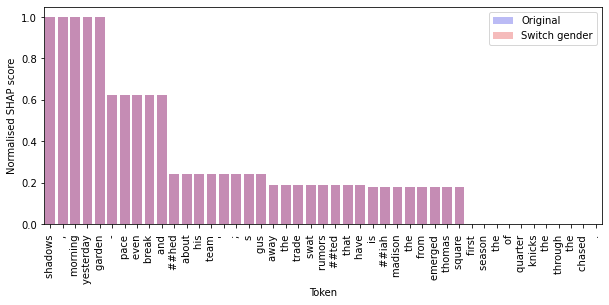

Original sentence: Minnesota Vikings head coach Mike Tice said that there are two or three college football jobs that could lure him from the NFL, according to the Seattle Post-Intelligencer.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


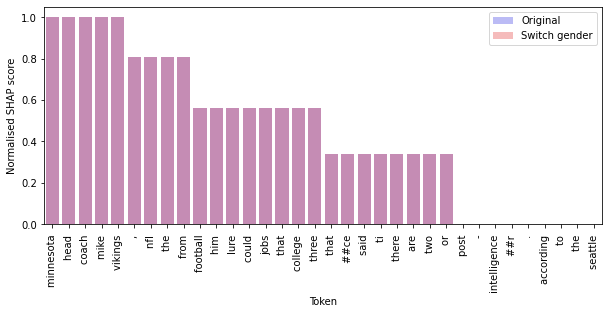

Original sentence:  SAN FRANCISCO (Reuters) - Hewlett-Packard Co. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=HPQ.N target=/stocks/quickinfo/fullquote"&gt;HPQ.N&lt;/A&gt; and  Intel Corp. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=INTC.O target=/stocks/quickinfo/fullquote"&gt;INTC.O&lt;/A&gt; on Wednesday ended their 10-year  partnership to co-develop the Itanium chip for server  computers, following disappointing sales of the product.
Model prediction: 2
Top-5 intersection: 0.4
Spearman: 0.98


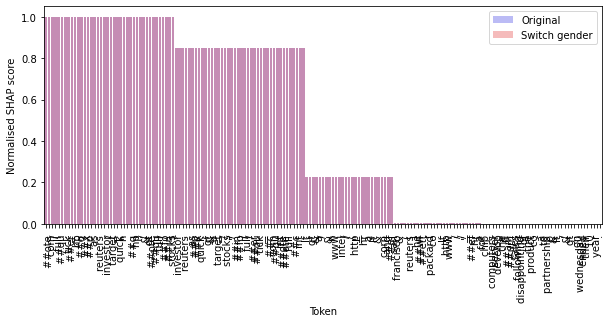




add_typo

Original sentence: As a young man, Recep Tayyip Erdogan was a gifted footballer; but not quite good enough to turn professional. So he concentrated on politics instead.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


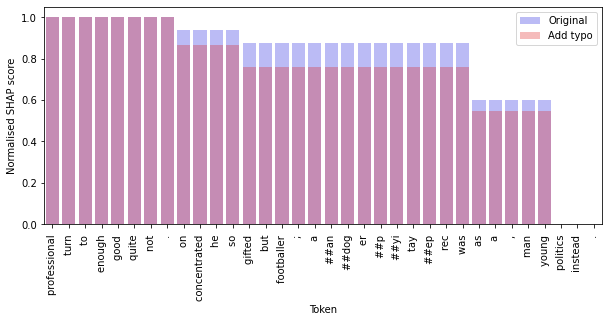

Original sentence: Minnesota will soon begin issuing new driver';s licenses that contain high-tech features to curb counterfeiting, as well as a  quot;status check quot; that will show a driver';s immigration status.
Model prediction: 3
Top-5 intersection: 0.4
Spearman: 0.98


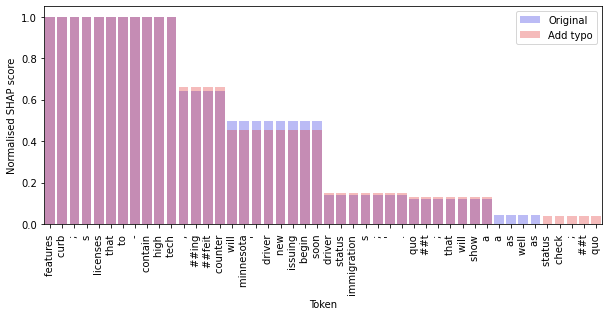

Original sentence: DEADLY floods, a bomb blast - reports on these were no match for news of this movie legend';s illness and death in the Philippines.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.99


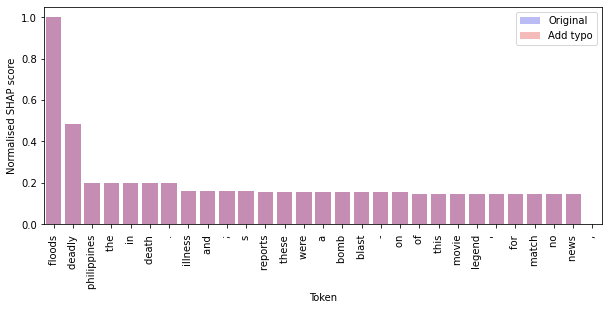

Original sentence: CHICAGO - The Cubs and shortstop Nomar Garciaparra have agreed to terms on a one-year deal worth $8 million. No option years were added to the contract.
Model prediction: 1
Top-5 intersection: 0.8
Spearman: 0.93


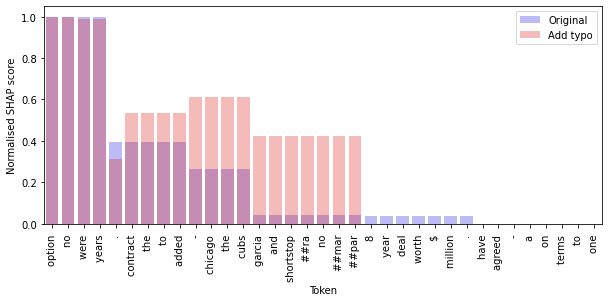

Original sentence: As details of the rumored merger between Sprint Corp. and Nextel Communications Inc. were being finalized behind closed doors late Tuesday, Miguel Avila, who heads Nextel's Hispanic marketing, summed up the mood of employees at the company's Reston headquarters.
Model prediction: 2
Top-5 intersection: 0.0
Spearman: 0.87


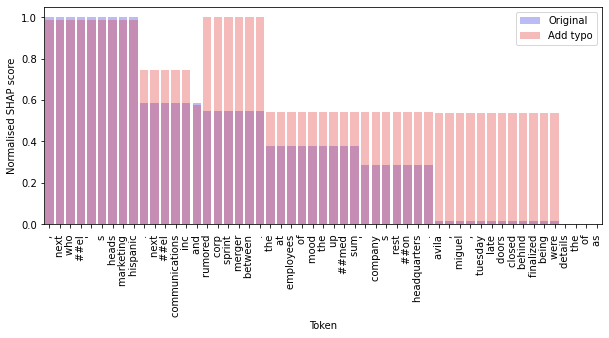




change_last_name

Original sentence: Dutch international Rafael van der Vaart was stripped of the Ajax Amsterdam captaincy on Thursday after he refused to play out of position in the Champions League game against Bayern Munich.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


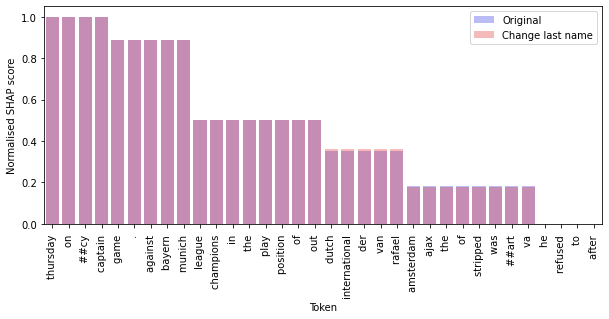

Original sentence: Dutch international Rafael van der Vaart was stripped of the Ajax Amsterdam captaincy on Thursday after he refused to play out of position in the Champions League game against Bayern Munich.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


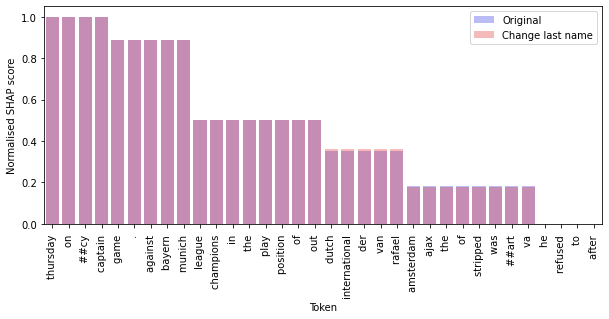

Original sentence: Dutch international Rafael van der Vaart was stripped of the Ajax Amsterdam captaincy on Thursday after he refused to play out of position in the Champions League game against Bayern Munich.
Model prediction: 1
Top-5 intersection: 1.0
Spearman: 1.0


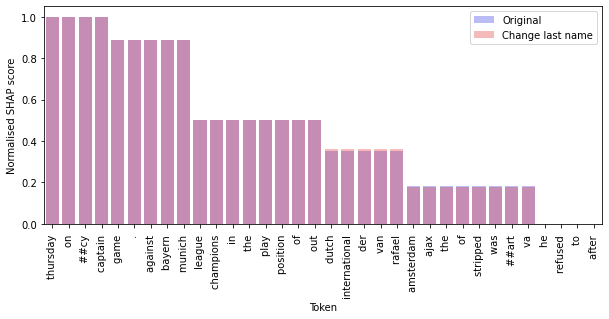

Original sentence:  RIO DE JANEIRO, Brazil (Reuters) - Police armed with rifles  and wearing flak jackets manned checkpoints across Rio de  Janeiro on Thursday to prevent muggings and other violence as  tourists flocked to the ocean city for the holiday season.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.98


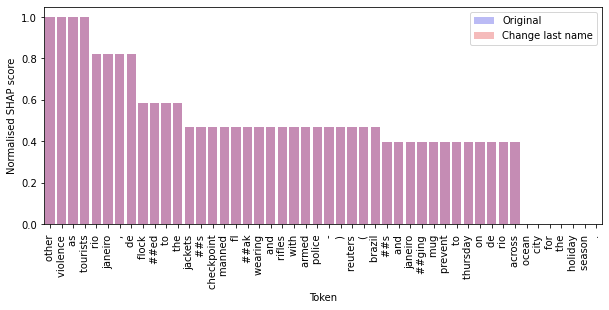

Original sentence:  RIO DE JANEIRO, Brazil (Reuters) - Police armed with rifles  and wearing flak jackets manned checkpoints across Rio de  Janeiro on Thursday to prevent muggings and other violence as  tourists flocked to the ocean city for the holiday season.
Model prediction: 0
Top-5 intersection: 1.0
Spearman: 0.98


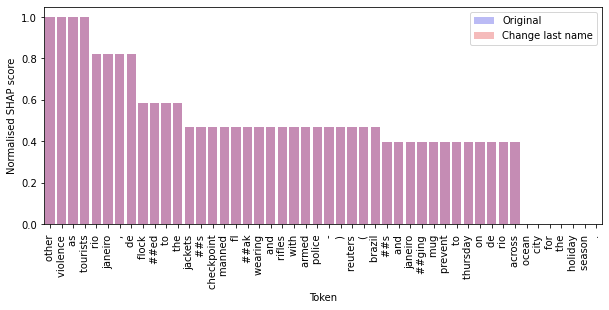

In [167]:
for pert in ['strip_punct', 'remove_commas', 'remove_all_punct', 'switch_gender', 'add_typo', 'change_last_name']:
    print(
f"""
================================================
{pert}
================================================
"""
)
    plot_examples(perturbation=pert, num_examples=5)
    print('\n')

## Check examples

In [168]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [169]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,the,1.0,the,0.527255
1,as,1.0,as,1.000000
2,deal,1.0,deal,0.527255
3,##making,1.0,##making,0.527255
4,hit,1.0,hit,0.527255


In [170]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [173]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [174]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
6,his,0.787040,her,0.772993
10,he,0.670185,she,0.748596
36,his,0.202197,her,0.271776


In [175]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [176]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
23,are,0.067444,care,0.018451
24,nec,0.067444,ne,0.018451


In [185]:
%%capture

pert = 'change_last_name'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [186]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_change_last_name_tokens,shap_change_last_name_values
20,van,0.349839,ramirez,0.360781


## TODOs

In [189]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'contraction', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender'])

In [188]:
len(perturbation_df_dict.keys())

9

In [190]:
for k, v in perturbation_df_dict.items():
    if v is None:
        print(k)

contraction
change_first_name
change_location


- Use same examples as Kirill (see Discord for indices)
- Correct top-k calculation in main notebook or drop and compute post-hoc
- Double check implementation of perturbations which led to lowest means e.g. `remove_commas`
- Add `swap_adj` implementation
- Drop `contraction`
- Use uppercase BERT tokenizer for perturbation df for the following perturbations:
    - contraction
    - change_first_name
    - change_location
- Comparison between correct prediction and incorrect predictions
- Intersection between explainers analysis (requires Kirill's results)